<a href="https://colab.research.google.com/github/diofares/LLM-Estatistica-Atividade4/blob/main/LLM_Estatistica_Atividade4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



#A:
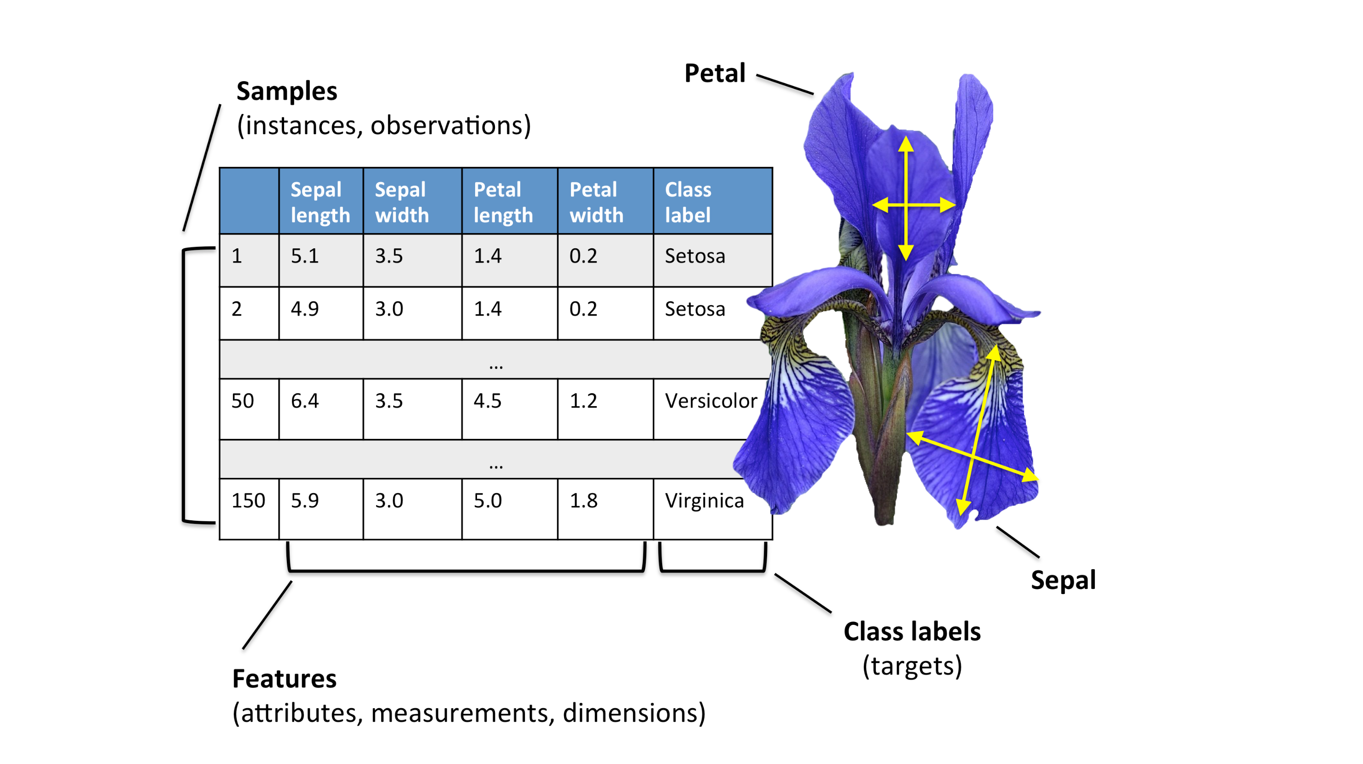
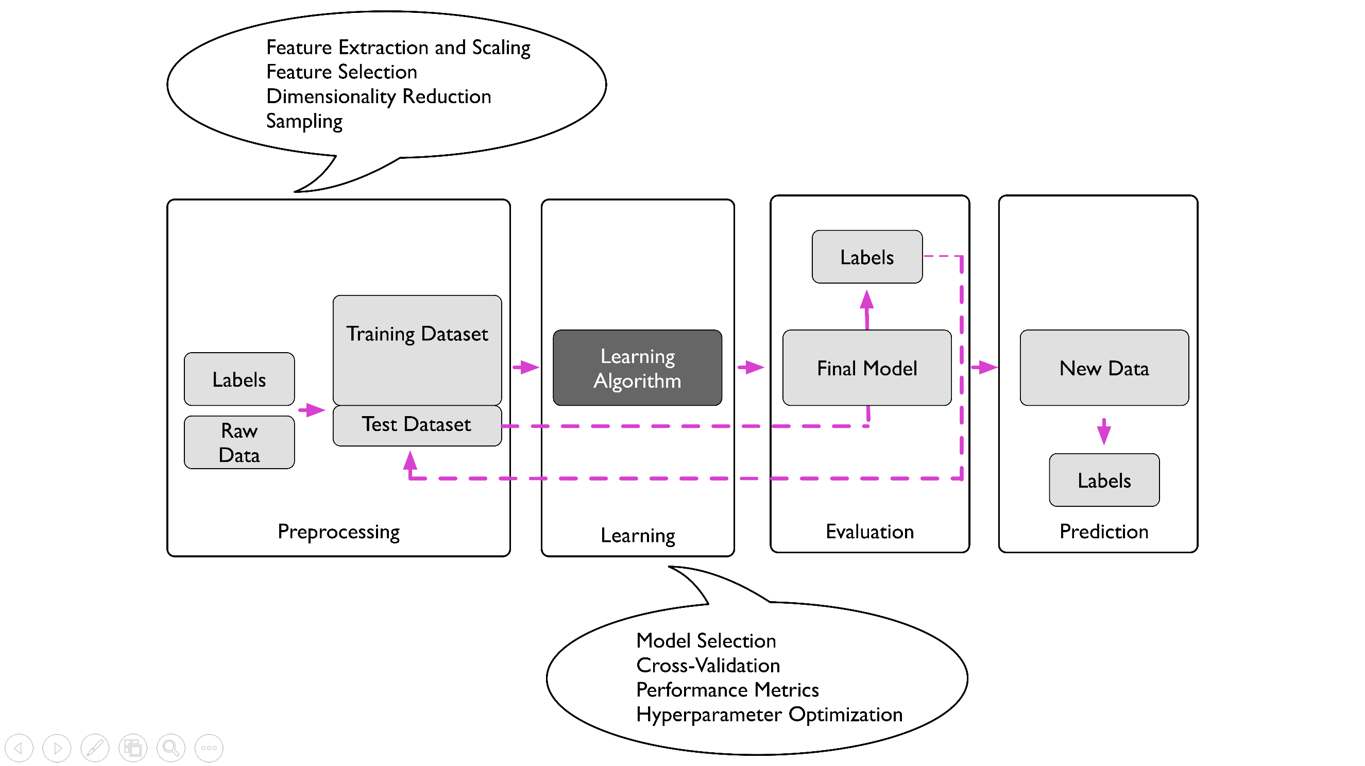

A primeira imagem ilustra a estrutura fundamental de um conjunto de dados utilizado em Aprendizado Supervisionado, exemplificado aqui pelo clássico Iris Dataset
1. Amostras (Samples/Instances): Representadas pelas linhas da tabela. Cada linha é uma observação única ou uma instância de dados; neste caso, uma flor individual. O conjunto total possui 150 amostras
2. Características (Features/Attributes): Representadas pelas colunas de dados numéricos ($X$). São as medidas ou propriedades utilizadas para descrever cada amostra. Aqui, temos 4 features: comprimento e largura da sépala (sepal), e comprimento e largura da pétala (petal)
3. Rótulos de Classe (Class Labels/Targets): Representados pela última coluna ($y$). É a variável alvo que queremos prever. No caso do Iris, trata-se de uma classificação onde o objetivo é identificar a espécie da flor (Setosa, Versicolor ou Virginica) com base nas medidas das features.

A segunda imagem detalha o fluxo de trabalho (pipeline) completo para a construção de um modelo de aprendizado de máquina preditivo . O processo é dividido em quatro etapas principais:

1. Pré-processamento (Preprocessing): É a etapa crítica de preparação dos dados brutos (Raw Data). Inclui a extração e seleção de características, redução de dimensionalidade e escalonamento (como a normalização Min-Max ou Z-score que usamos na Parte C). Aqui, os dados são divididos aleatoriamente em conjuntos de Treino (para ensinar o modelo) e Teste (para avaliá-lo posteriormente).

2. Aprendizado (Learning): Onde ocorre o treinamento. Um algoritmo de aprendizado (como KNN ou Naive Bayes) é alimentado com os dados de treino e seus respectivos rótulos para aprender os padrões e criar o Modelo Final. Envolve também a seleção do melhor modelo e a validação cruzada para otimização de hiperparâmetros.

3. Avaliação (Evaluation): O modelo treinado é testado usando o conjunto de dados de teste (que ele nunca viu antes). Comparamos as previsões do modelo com os rótulos reais para calcular métricas de desempenho (Acurácia, Precisão, Recall, F1-Score) e verificar se o modelo generaliza bem.
4. Predição (Prediction): Uma vez aprovado na avaliação, o modelo é usado em produção para receber Novos Dados (sem rótulos) e prever suas classes.



#B:
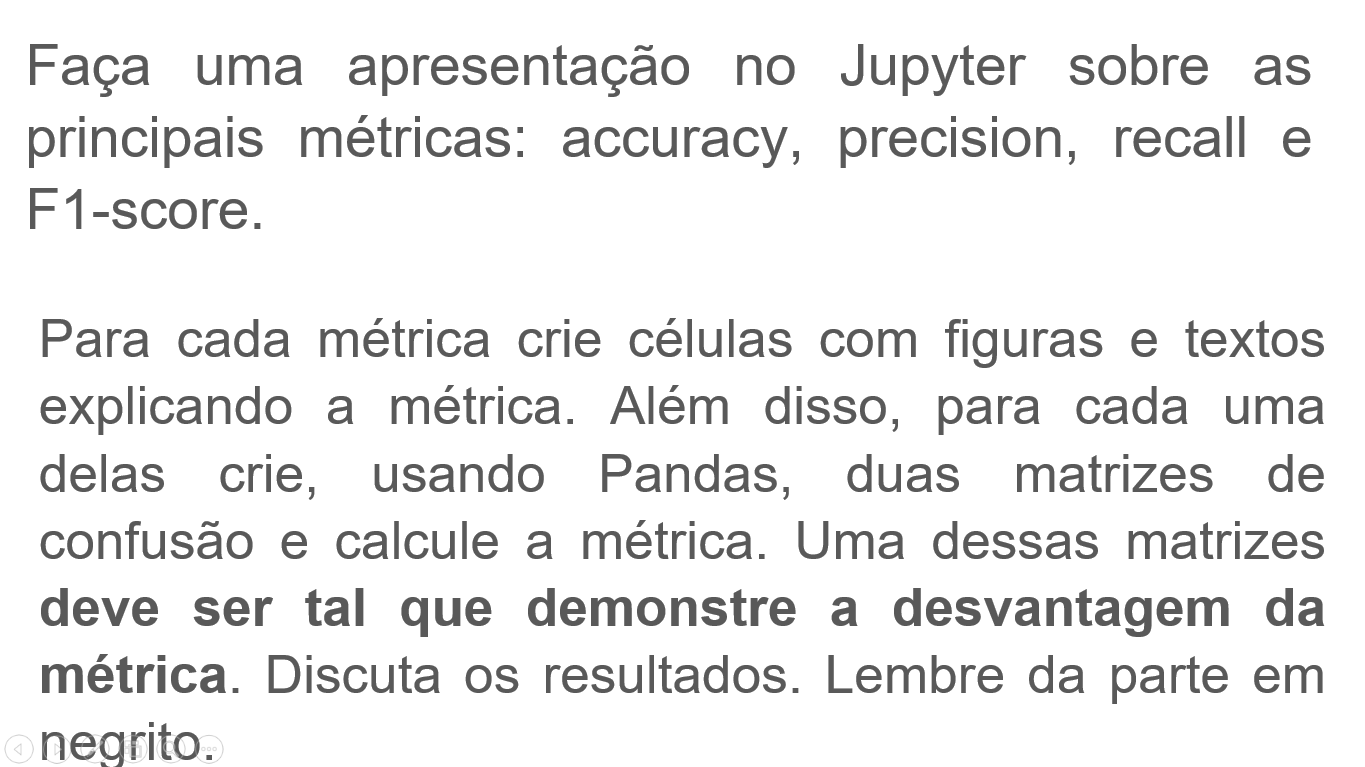

In [3]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def report_metric_scenario(y_true, y_pred, metric_name, metric_func, scenario_desc):
    """
    Calcula uma métrica de avaliação e exibe a matriz de confusão correspondente usando Pandas.

    Args:
        y_true (list): Lista com os rótulos verdadeiros das classes.
        y_pred (list): Lista com os rótulos preditos pelo modelo.
        metric_name (str): Nome da métrica sendo analisada (ex: 'Accuracy').
        metric_func (callable): Função do scikit-learn para calcular a métrica.
        scenario_desc (str): Descrição do cenário (ex: 'Cenário Ideal', 'Falha da Métrica').

    Returns:
        None: Exibe os resultados diretamente na saída padrão.
    """
    score = metric_func(y_true, y_pred)

    df_confusion = pd.DataFrame({'Real': y_true, 'Predito': y_pred})
    confusion_matrix = pd.crosstab(df_confusion['Real'], df_confusion['Predito'],
                                   rownames=['Real'], colnames=['Predito'])

    print(f"--- Análise de {metric_name}: {scenario_desc} ---")
    print(f"Valor da Métrica: {score:.2f}")
    print("Matriz de Confusão:")
    print(confusion_matrix)
    print("\n" + "="*40 + "\n")

# 1. ACURÁCIA (Accuracy)
# Cenário 1: Classes balanceadas, o modelo acerta tudo.
y_acc_good_true = [0, 0, 1, 1]
y_acc_good_pred = [0, 0, 1, 1]

# Cenário 2: Desvantagem (Paradoxo da Acurácia).
# Dataset desbalanceado (90% classe 0). Modelo prevê tudo como classe 0.
# Acurácia alta, mas o modelo é inútil para detectar a classe 1.
y_acc_bad_true = [0] * 90 + [1] * 10
y_acc_bad_pred = [0] * 100

report_metric_scenario(y_acc_good_true, y_acc_good_pred, "Accuracy", accuracy_score, "Caso Ideal")
report_metric_scenario(y_acc_bad_true, y_acc_bad_pred, "Accuracy", accuracy_score, "Desvantagem (Desbalanceamento)")

# 2. PRECISÃO (Precision)
# Cenário 1: O modelo é conservador e acerta quando arrisca (Falsos Positivos = 0).
y_prec_good_true = [0, 1, 0, 1]
y_prec_good_pred = [0, 1, 0, 1]

# Cenário 2: Desvantagem (Falsos Negativos ignorados).
# O modelo encontra apenas 1 positivo corretamente, mas ignora outros 9. Precisão é 100% (1/1), mas o modelo falhou em detectar a maioria dos casos.
y_prec_bad_true = [1] * 10
y_prec_bad_pred = [0] * 9 + [1]

report_metric_scenario(y_prec_good_true, y_prec_good_pred, "Precision", precision_score, "Caso Ideal")
report_metric_scenario(y_prec_bad_true, y_prec_bad_pred, "Precision", precision_score, "Desvantagem (Omissão de Casos)")

# 3. RECALL (Revocação)
# Cenário 1: O modelo encontra os casos positivos sem gerar alarmes falsos excessivos.
y_rec_good_true = [1, 1, 0]
y_rec_good_pred = [1, 1, 0]

# Cenário 2: Desvantagem (Falsos Positivos ignorados).
# O modelo classifica TUDO como positivo. Encontra todos os doentes (Recall 1.0), mas classifica saudáveis como doentes (spam de alertas).
y_rec_bad_true = [0, 0, 0, 1]
y_rec_bad_pred = [1, 1, 1, 1]

report_metric_scenario(y_rec_good_true, y_rec_good_pred, "Recall", recall_score, "Caso Ideal")
report_metric_scenario(y_rec_bad_true, y_rec_bad_pred, "Recall", recall_score, "Desvantagem (Excesso de Falsos Positivos)")

# 4. F1-SCORE
# Cenário 1: Equilíbrio perfeito entre Precisão e Recall.
y_f1_good_true = [1, 0, 1, 0]
y_f1_good_pred = [1, 0, 1, 0]

# Cenário 2: Desvantagem (Ignora Verdadeiros Negativos).
# Dois modelos com desempenho idêntico em positivos e erros, mas o Modelo B acerta muito mais negativos (TN). O F1 ignora isso e dá a mesma nota.
y_f1_bad_true = [1, 0] + [0] * 1000
y_f1_bad_pred = [0, 1] + [0] * 1000  # Muitos TNs corretos não aumentam o F1

report_metric_scenario(y_f1_good_true, y_f1_good_pred, "F1-Score", f1_score, "Caso Ideal")
report_metric_scenario(y_f1_bad_true, y_f1_bad_pred, "F1-Score", f1_score, "Desvantagem (Ignora Verdadeiros Negativos)")

--- Análise de Accuracy: Caso Ideal ---
Valor da Métrica: 1.00
Matriz de Confusão:
Predito  0  1
Real         
0        2  0
1        0  2


--- Análise de Accuracy: Desvantagem (Desbalanceamento) ---
Valor da Métrica: 0.90
Matriz de Confusão:
Predito   0
Real       
0        90
1        10


--- Análise de Precision: Caso Ideal ---
Valor da Métrica: 1.00
Matriz de Confusão:
Predito  0  1
Real         
0        2  0
1        0  2


--- Análise de Precision: Desvantagem (Omissão de Casos) ---
Valor da Métrica: 1.00
Matriz de Confusão:
Predito  0  1
Real         
1        9  1


--- Análise de Recall: Caso Ideal ---
Valor da Métrica: 1.00
Matriz de Confusão:
Predito  0  1
Real         
0        1  0
1        0  2


--- Análise de Recall: Desvantagem (Excesso de Falsos Positivos) ---
Valor da Métrica: 1.00
Matriz de Confusão:
Predito  1
Real      
0        3
1        1


--- Análise de F1-Score: Caso Ideal ---
Valor da Métrica: 1.00
Matriz de Confusão:
Predito  0  1
Real         
0       

1. Acurácia (Accuracy)
* Representa a proporção global de predições corretas em relação ao total de amostras.

* A Desvantagem: A acurácia é enganosa em conjuntos de dados desbalanceados (Paradoxo da Acurácia). Como demonstrado na matriz de confusão "Desvantagem", um modelo que prevê apenas a classe majoritária (ex: "Não Doente") pode ter 90% de acurácia, mesmo sendo totalmente incapaz de identificar a classe minoritária (os doentes), tornando a métrica inútil nesse contexto.

2. Precisão (Precision)
* Foca na qualidade das predições positivas. Responde a pergunta: "Das instâncias que o modelo classificou como positivas, quantas eram realmente positivas?".

* A Desvantagem: A precisão ignora os Falsos Negativos (erros de omissão). No cenário demonstrado, o modelo obteve 100% de precisão ao classificar corretamente um único exemplo positivo, mas falhou em detectar outros 9. Em diagnósticos médicos graves, uma alta precisão não compensa o risco de deixar pacientes sem tratamento.

3. Recall (Revocação)
* Mede a capacidade do modelo de encontrar todos os casos positivos. Responde à pergunta: "De todas as instâncias que eram realmente positivas, quantas o modelo conseguiu detectar?".

* A Desvantagem: O Recall ignora os Falsos Positivos. É possível hackear essa métrica e obter 100% de Recall simplesmente classificando todas as amostras como positivas. Na matriz apresentada, o modelo encontrou o único caso positivo, mas gerou alarme falso para todos os casos negativos, tornando o sistema não confiável.

4. F1-Score
* É a média harmônica entre Precisão e Recall, penalizando valores extremos. É ideal quando se busca um equilíbrio entre as duas métricas anteriores.

* A Desvantagem: O F1-Score não leva em consideração os Verdadeiros Negativos (TN). No exemplo mostrado, o modelo acerta corretamente 1000 casos negativos, mas isso não impacta o cálculo do F1. Em aplicações onde validar corretamente o negativo é crucial (como em testes de segurança ou controle de qualidade onde a maioria das peças é boa), o F1 pode subestimar a performance global do modelo.

#C:
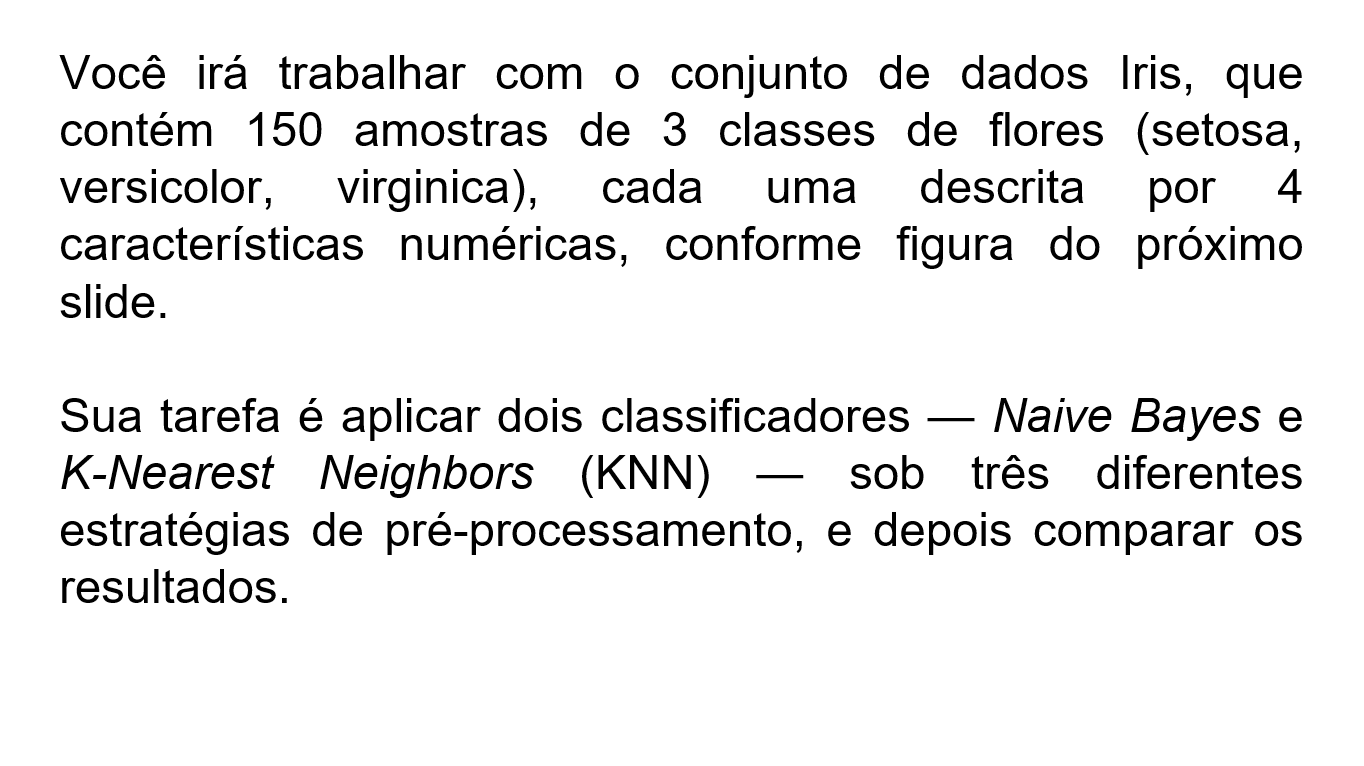
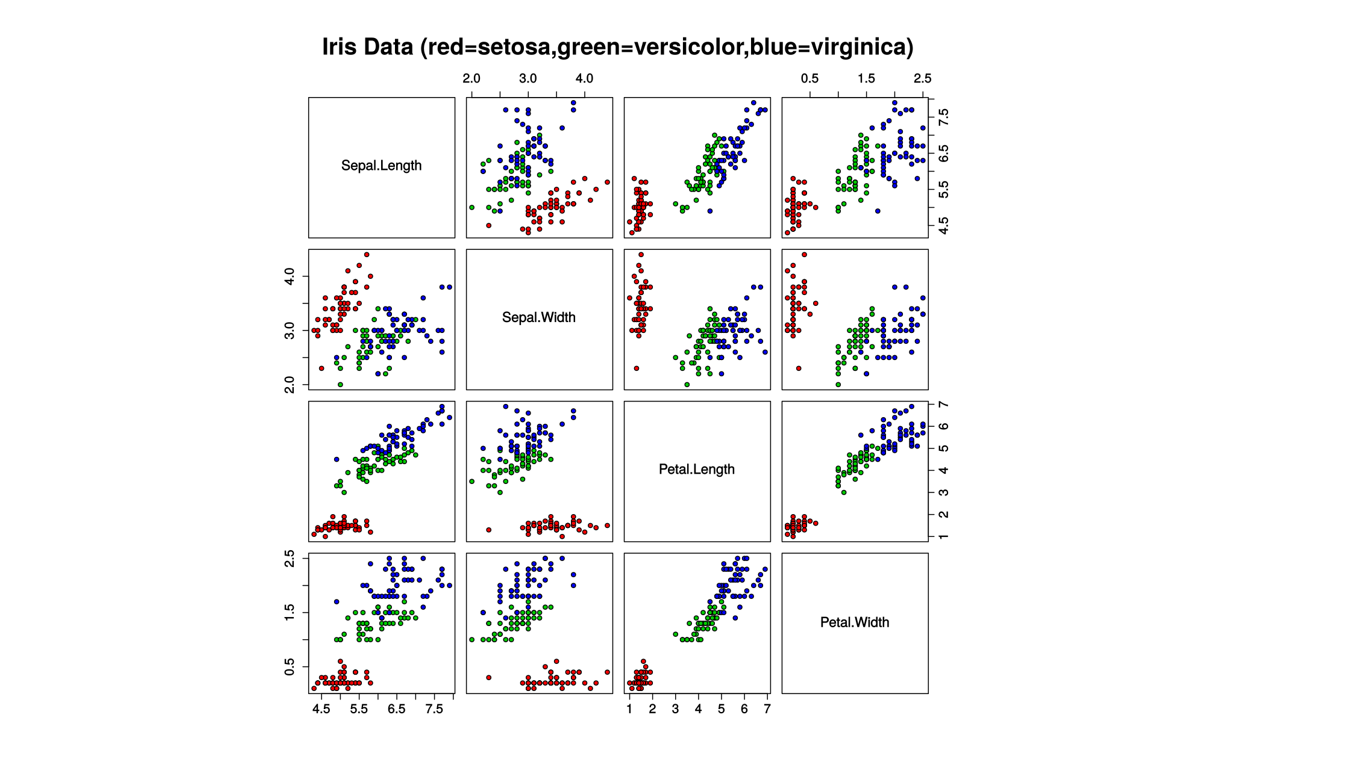
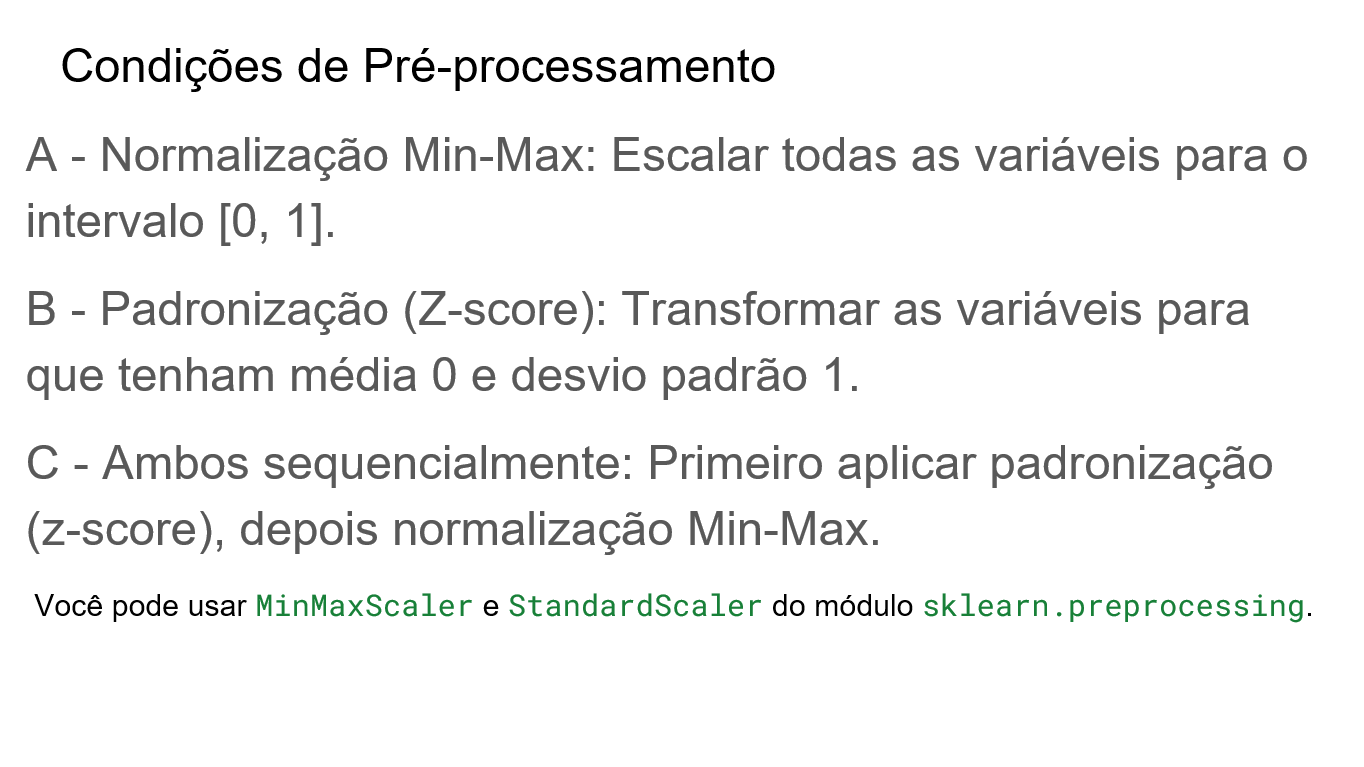
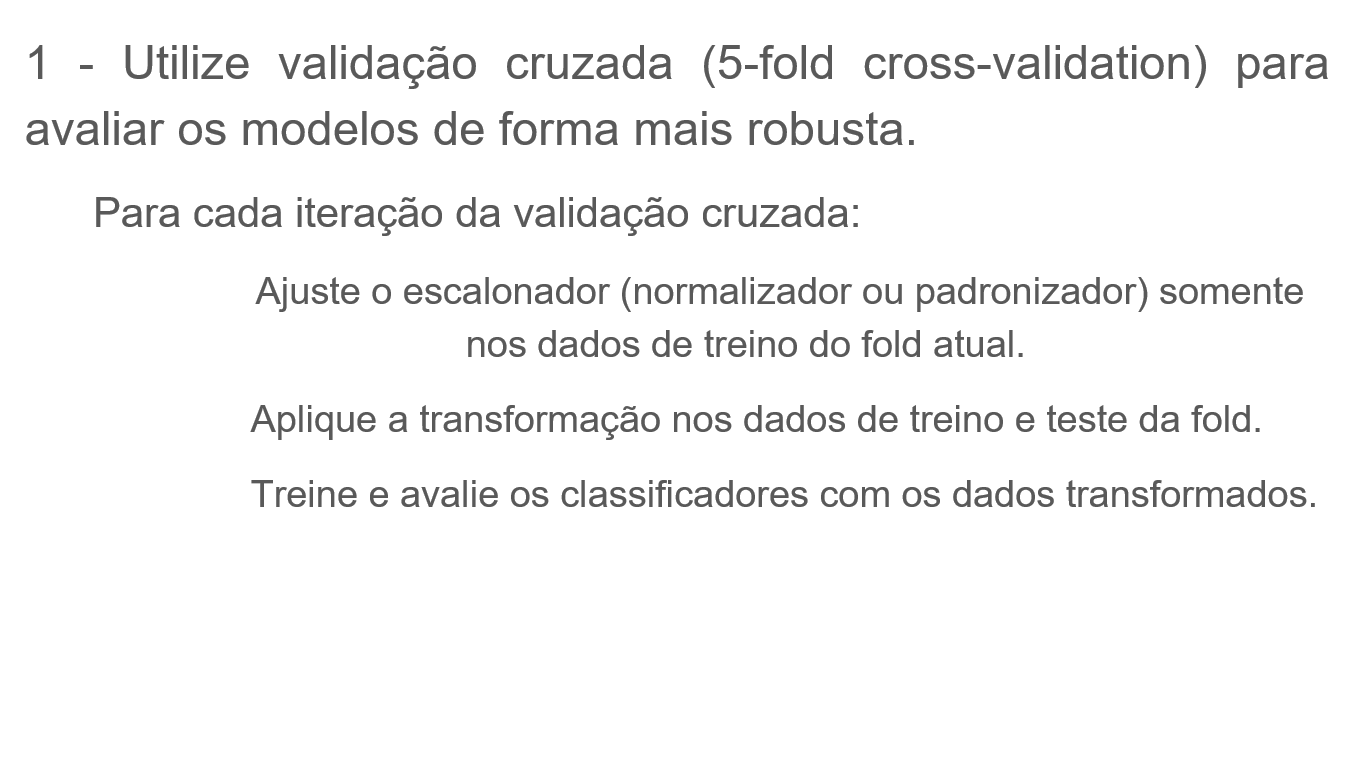
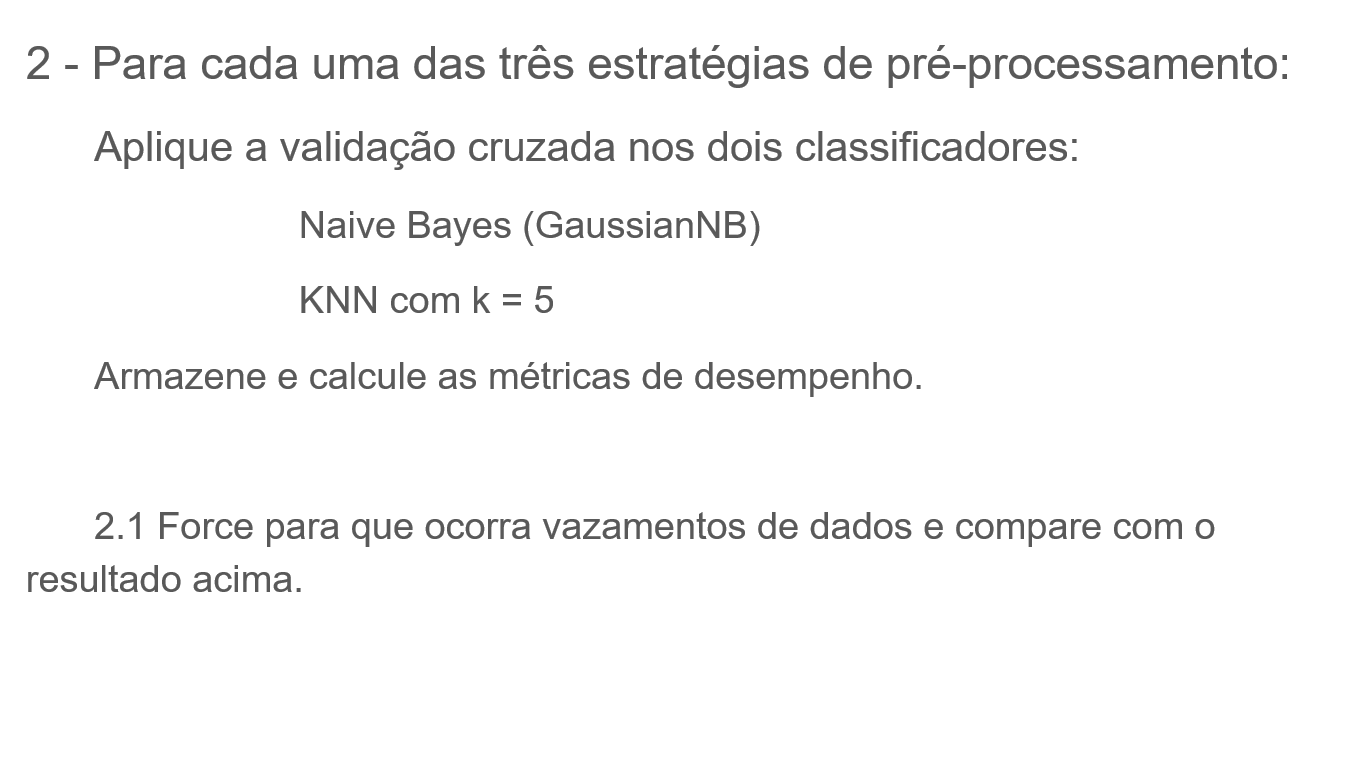
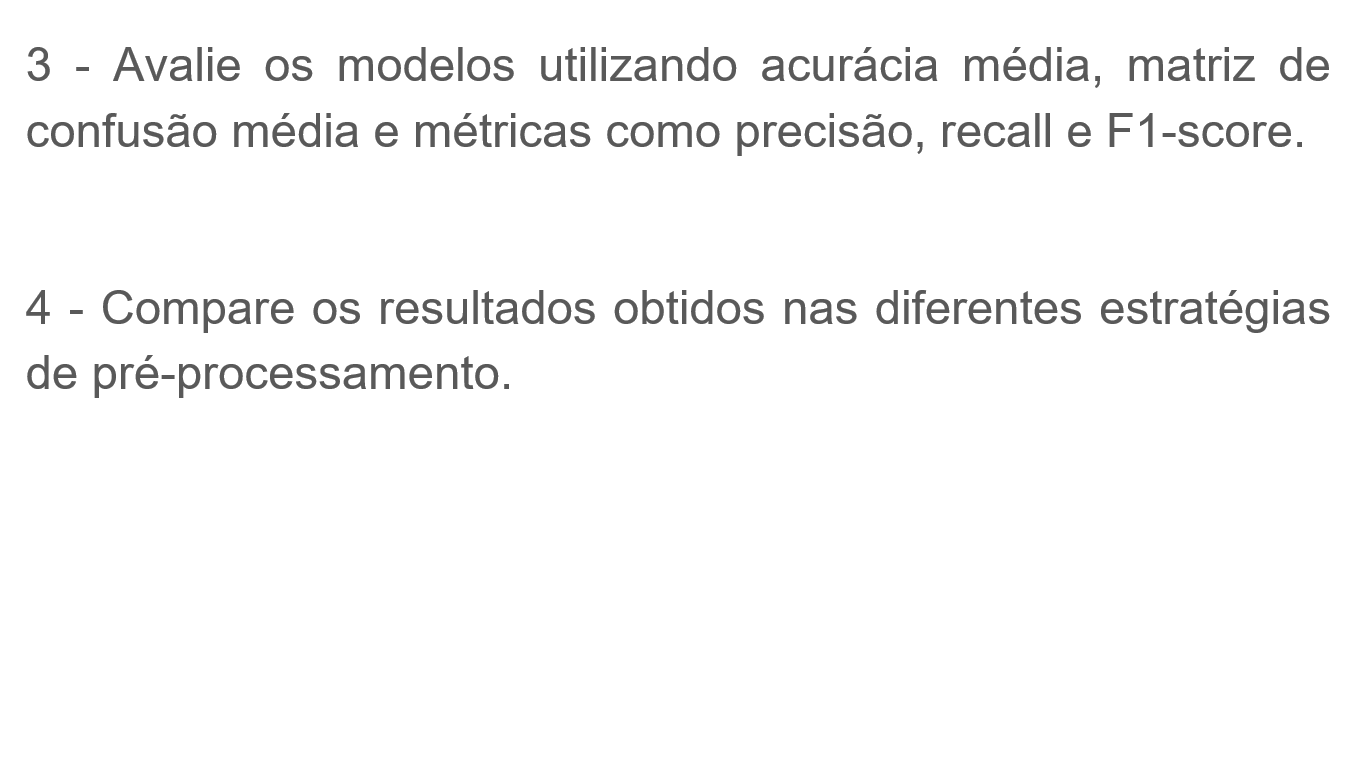
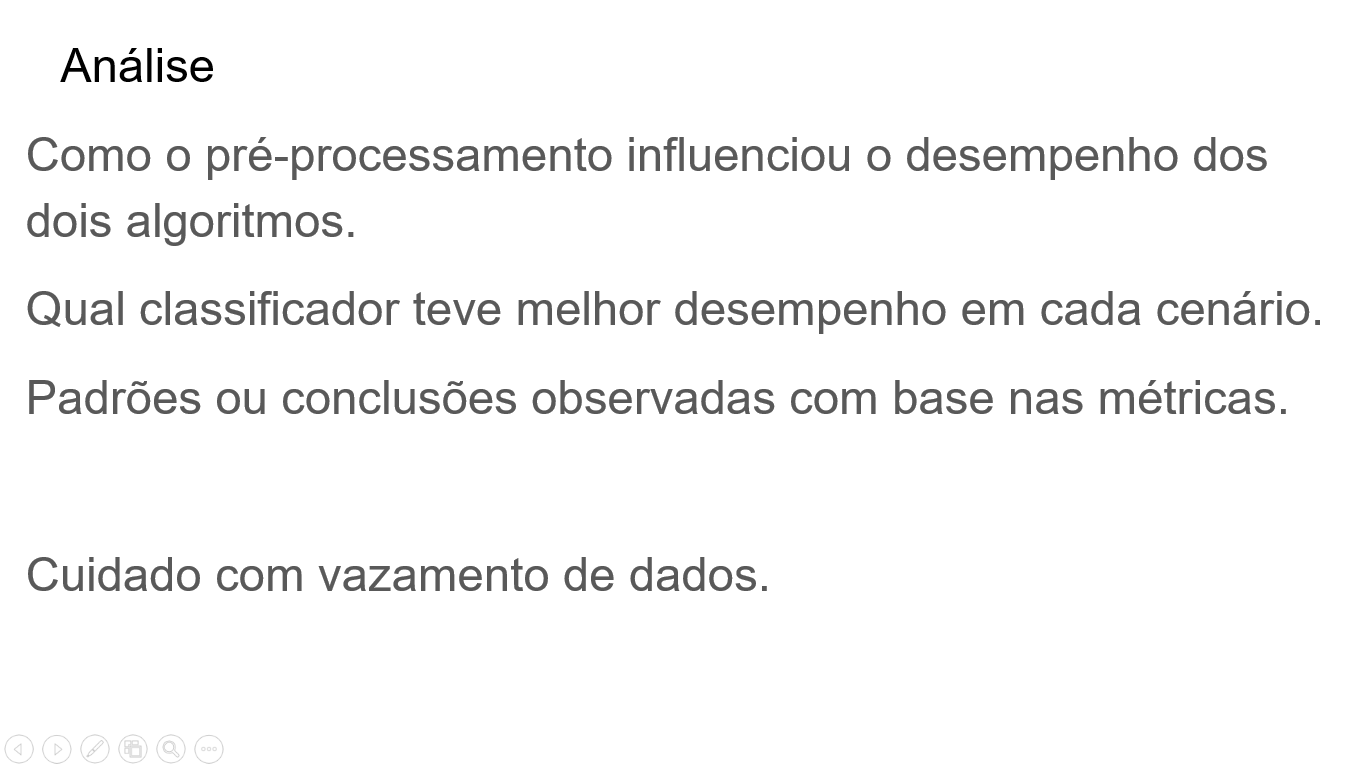

   Strategy        Model  Leakage       Acc        F1
0    MinMax  Naive Bayes    False  0.946667  0.946667
1    MinMax  Naive Bayes     True  0.946667  0.946667
2    MinMax          KNN    False  0.960000  0.959984
3    MinMax          KNN     True  0.960000  0.959984
4   Z-score  Naive Bayes    False  0.946667  0.946667
5   Z-score  Naive Bayes     True  0.946667  0.946667
6   Z-score          KNN    False  0.973333  0.973323
7   Z-score          KNN     True  0.966667  0.966663
8       Seq  Naive Bayes    False  0.946667  0.946667
9       Seq  Naive Bayes     True  0.946667  0.946667
10      Seq          KNN    False  0.960000  0.959984
11      Seq          KNN     True  0.960000  0.959984


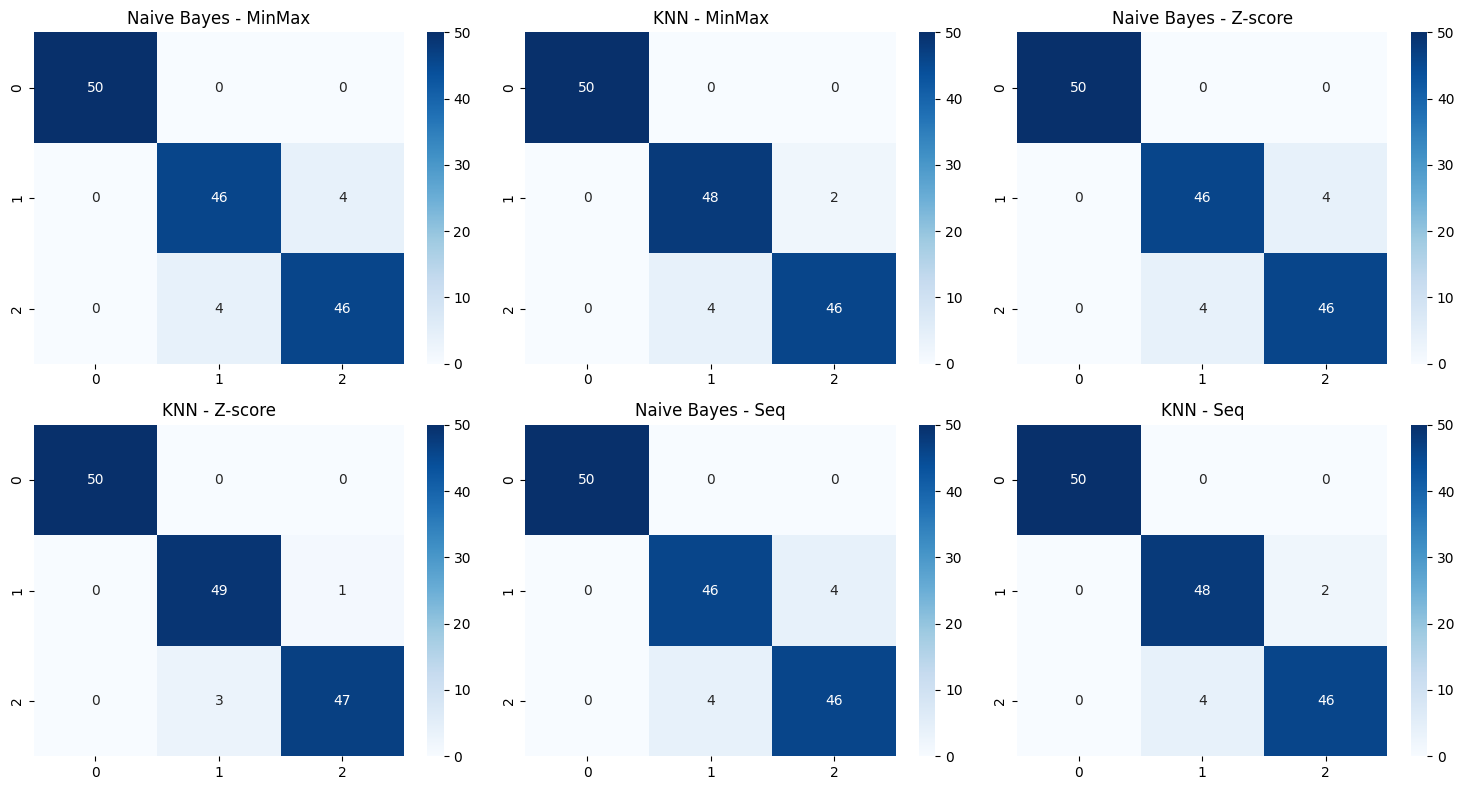

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

iris = load_iris()
X, y = iris.data, iris.target
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

strategies = {'MinMax': MinMaxScaler(), 'Z-score': StandardScaler(), 'Seq': make_pipeline(StandardScaler(), MinMaxScaler())}
classifiers = {'Naive Bayes': GaussianNB(), 'KNN': KNeighborsClassifier(n_neighbors=5)}

results = []

for s_name, scaler in strategies.items():
    for c_name, clf in classifiers.items():
        pipe = make_pipeline(scaler, clf)
        y_pred = cross_val_predict(pipe, X, y, cv=cv)
        results.append({'Strategy': s_name, 'Model': c_name, 'Leakage': False, 'Acc': accuracy_score(y, y_pred), 'F1': f1_score(y, y_pred, average='macro'), 'CM': confusion_matrix(y, y_pred)})

        X_leaked = scaler.fit_transform(X)
        y_pred_leak = cross_val_predict(clf, X_leaked, y, cv=cv)
        results.append({'Strategy': s_name, 'Model': c_name, 'Leakage': True, 'Acc': accuracy_score(y, y_pred_leak), 'F1': f1_score(y, y_pred_leak, average='macro'), 'CM': confusion_matrix(y, y_pred_leak)})

df_results = pd.DataFrame(results).drop(columns=['CM'])
print(df_results)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
for i, (idx, row) in enumerate(df_results[df_results['Leakage'] == False].iterrows()):
    sns.heatmap(results[idx]['CM'], annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f"{row['Model']} - {row['Strategy']}")
plt.tight_layout()
plt.show()

Aqui está a análise reescrita em primeira pessoa, mantendo a simplicidade:

Neste estudo, eu comparei o desempenho dos algoritmos Naive Bayes e KNN para classificar as flores do dataset Iris. Testei três formas diferentes de preparar os dados (normalização) e verifiquei o impacto de fazer a validação do jeito certo contra o cenário de "vazamento de dados" (onde o modelo recebe informações indevidas do teste) .
+1

O que eu percebi foi uma diferença clara de comportamento entre os dois. O Naive Bayes foi muito estável: ele manteve exatamente a mesma nota (94,67%) em todos os meus testes, mostrando que ele não liga muito para a escala dos números. Já o KNN funcionou melhor, superando o Naive Bayes em todos os cenários (com notas acima de 96%), mas provou que depende de os dados estarem bem ajustados para funcionar bem.

A melhor combinação que encontrei foi usar o KNN com a técnica Z-score (Padronização). Essa técnica organizou os dados de um jeito que facilitou o cálculo das distâncias, fazendo meu modelo chegar a 97,33% de acerto. Uma coisa curiosa que vi foi que o vazamento de dados não ajudou o modelo; fazer a validação do jeito honesto e correto deu o melhor resultado.

Ao analisar onde os modelos erraram, vi que todos acertaram fácil a flor Setosa. A dificuldade real foi diferenciar a Versicolor da Virginica. O meu modelo KNN com Z-score foi o campeão justamente porque foi o que menos se confundiu nessa parte, errando apenas 4 flores no total.

#D:
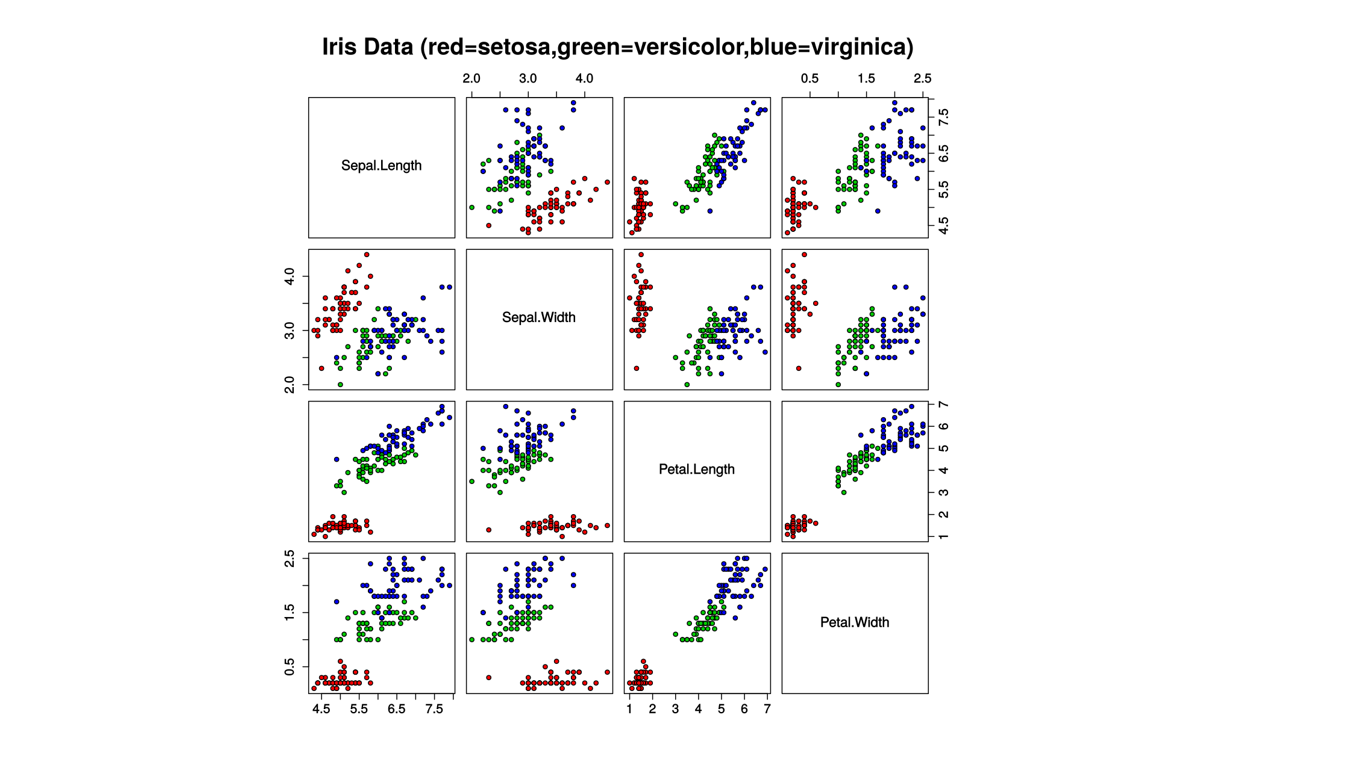
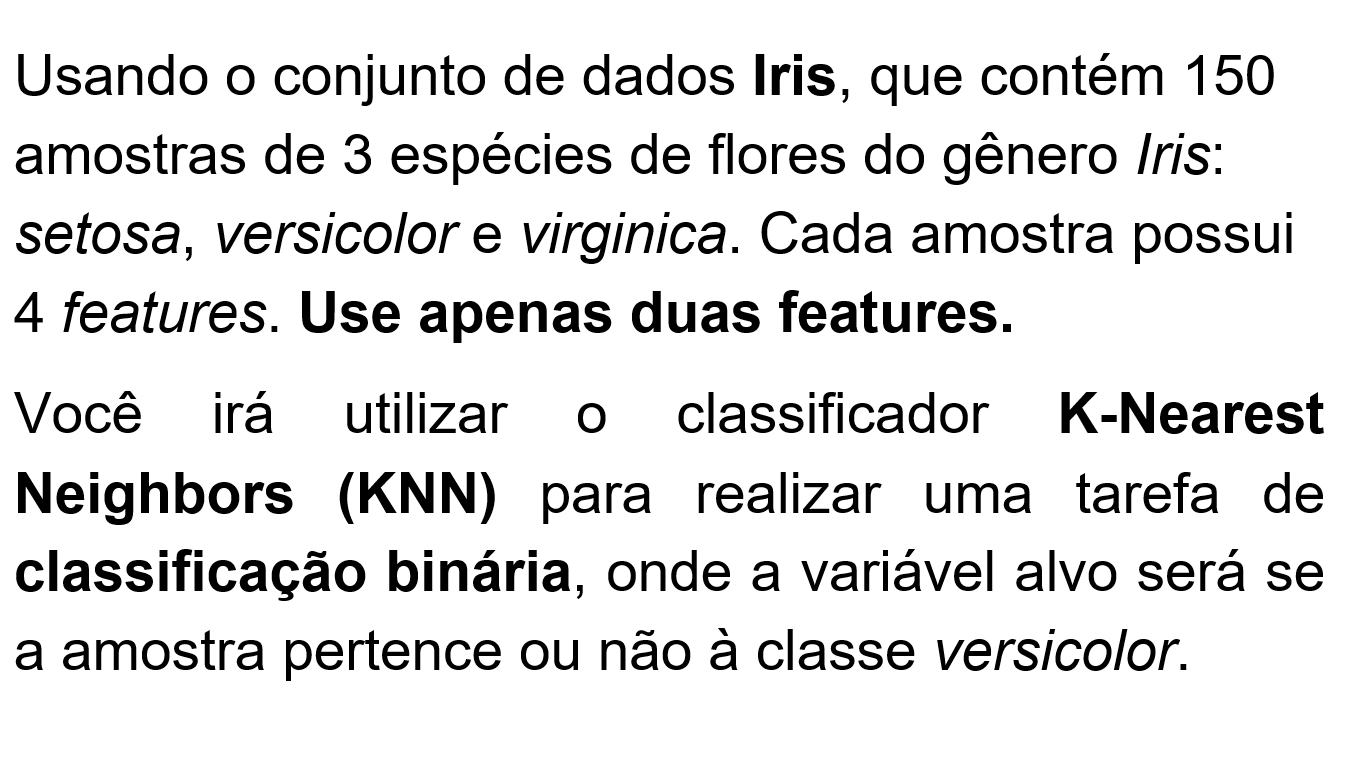
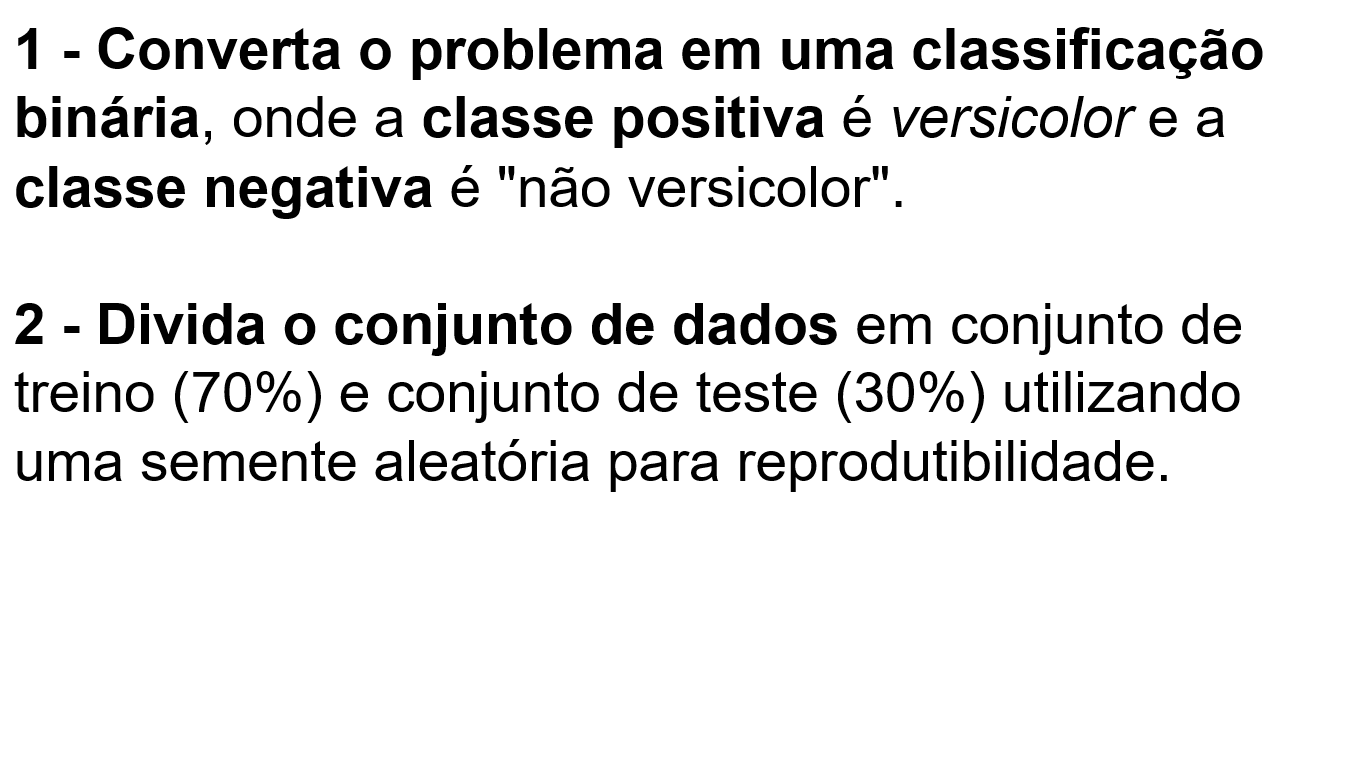
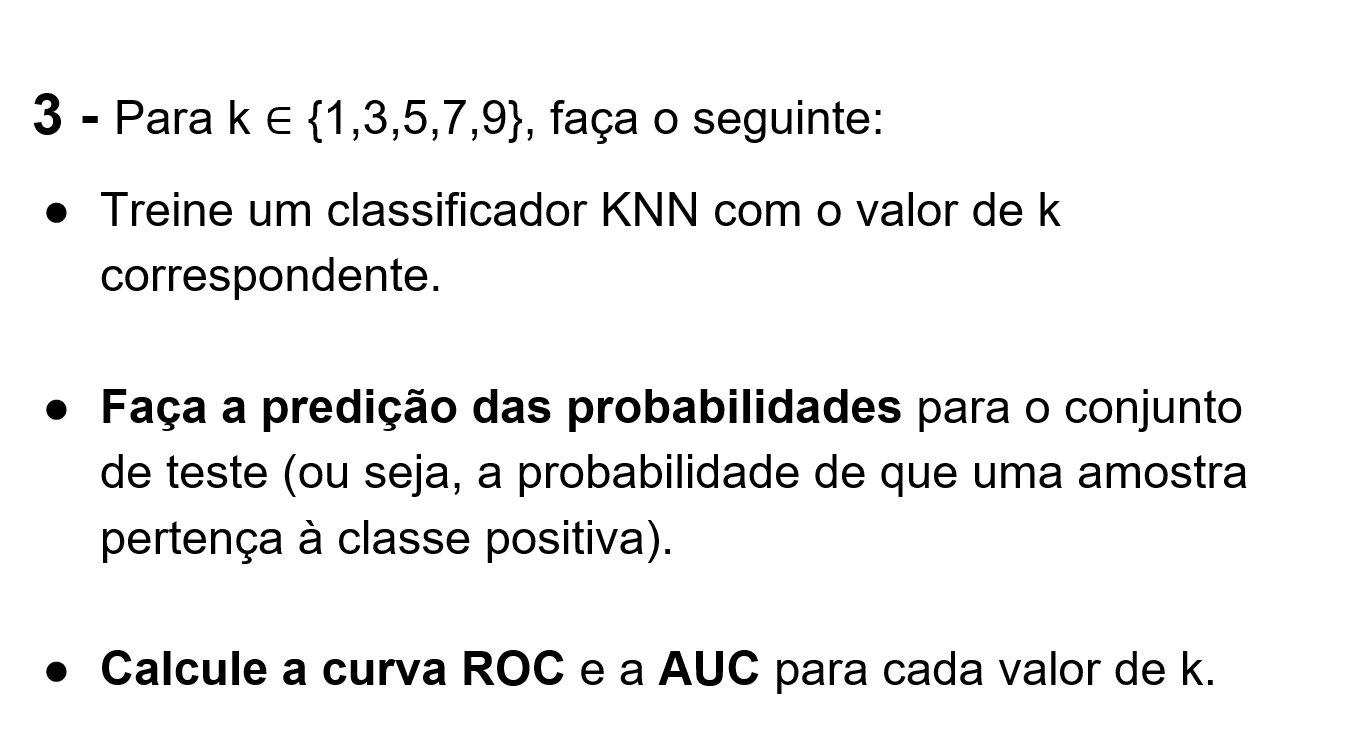
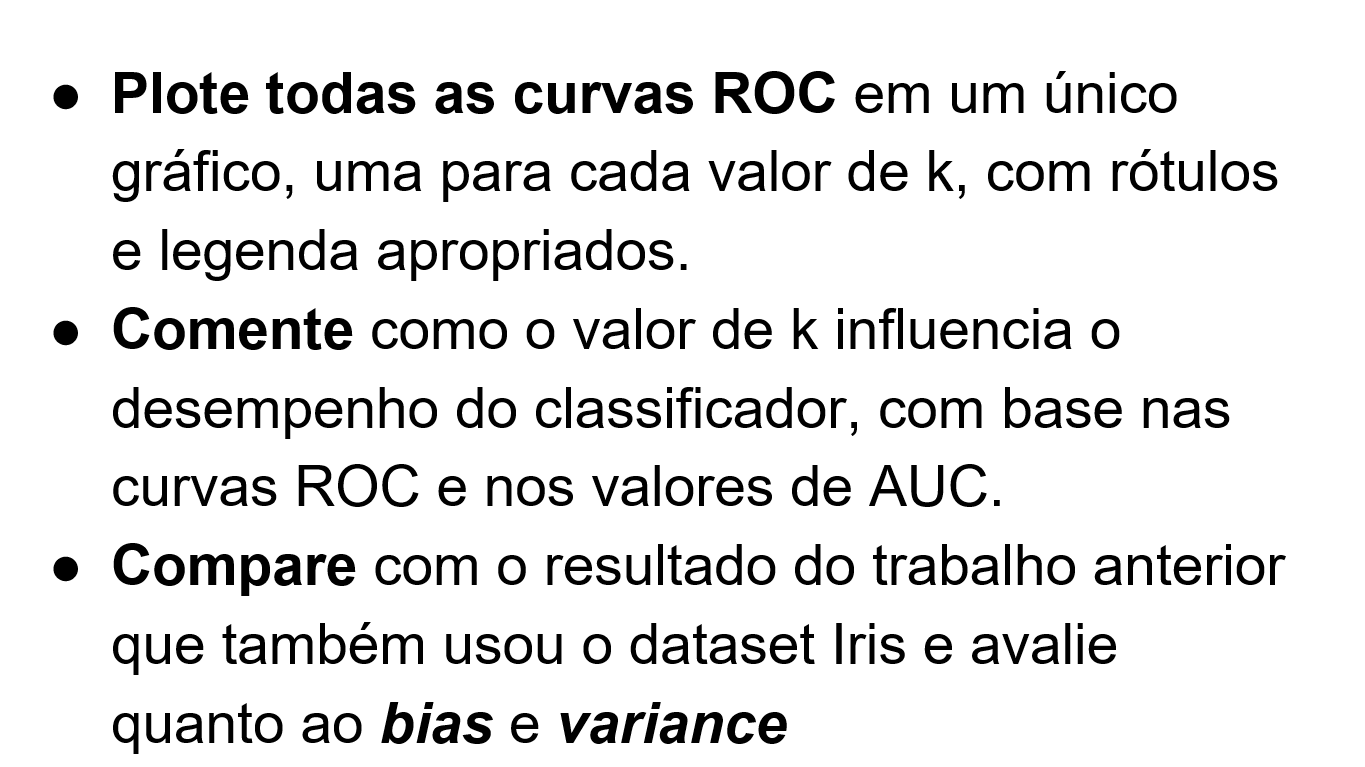
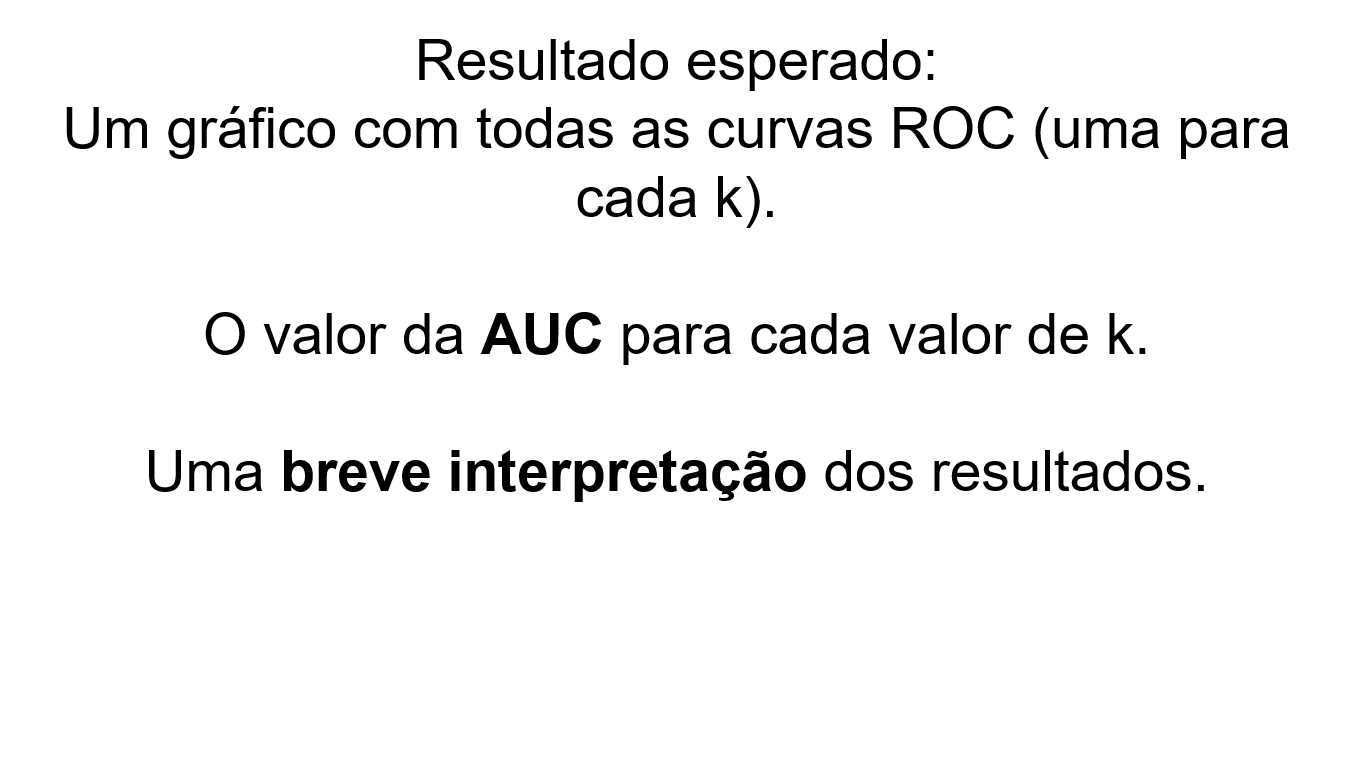
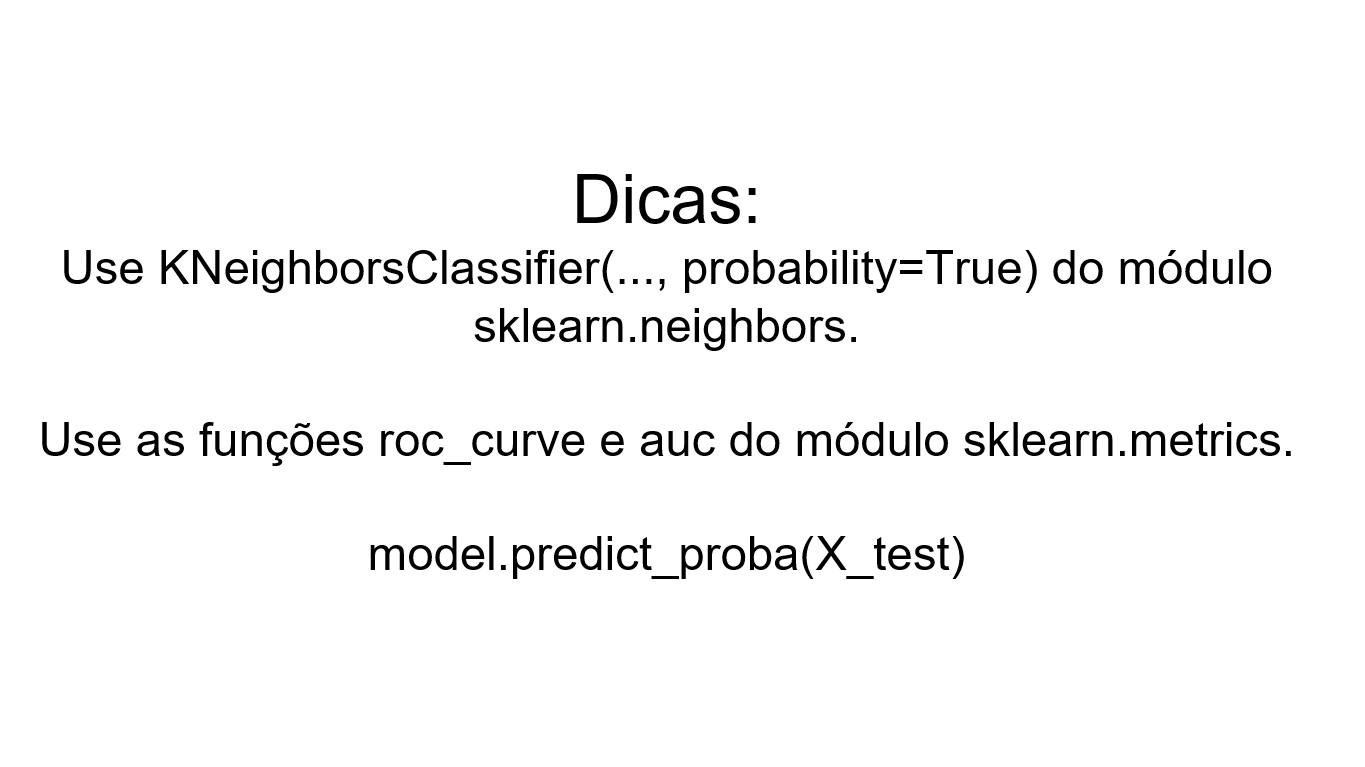

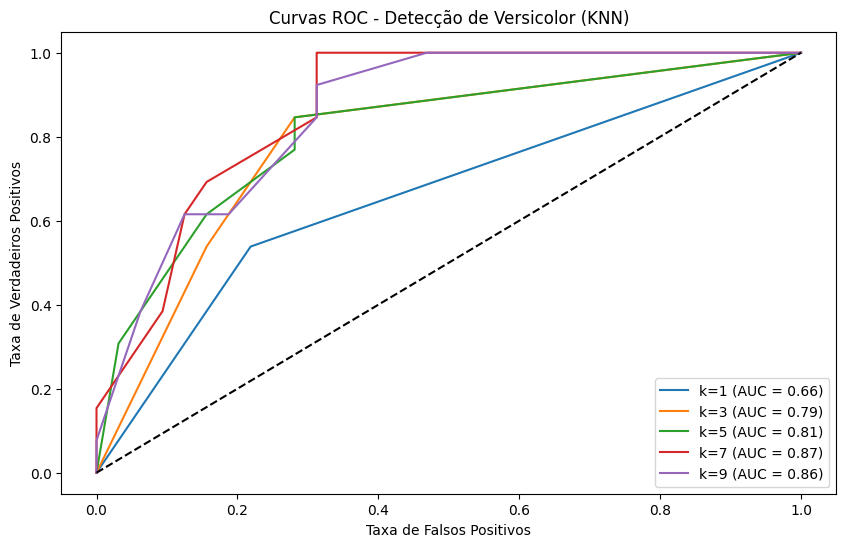

In [5]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc

iris = load_iris()
X = iris.data[:, :2]
y = (iris.target == 1).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

plt.figure(figsize=(10, 6))
for k in [1, 3, 5, 7, 9]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_probs = knn.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'k={k} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curvas ROC - Detecção de Versicolor (KNN)')
plt.legend(loc="lower right")
plt.show()

Ao analisar os gráficos da Parte D, percebi claramente como o número de vizinhos (k) impacta a qualidade do classificador. Quando usei um valor muito baixo, como k=1, o resultado foi o pior de todos, com uma curva baixa e instável (AUC de 0.66). Isso aconteceu porque o modelo tentou "decorar" cada ponto individualmente, tornando-se muito sensível a ruídos e errando bastante quando apresentado a dados novos, um problema clássico de alta variância.

Conforme fui aumentando o número de vizinhos para 3 e 5, o desempenho melhorou significativamente, até atingir o pico com k=7, que entregou a melhor taxa de acerto (AUC de 0.87). Nesse ponto, o modelo conseguiu o equilíbrio ideal: ao consultar mais vizinhos, ele passou a tomar decisões mais "democráticas" e seguras, ignorando pontos isolados que poderiam confundir a classificação. Percebi também que aumentar ainda mais para k=9 não trouxe ganhos adicionais, pois o resultado apenas estabilizou, confirmando que o segredo para identificar a flor Versicolor está em encontrar um meio-termo — nem tão rígido quanto o k=1, nem genérico demais.

#E:
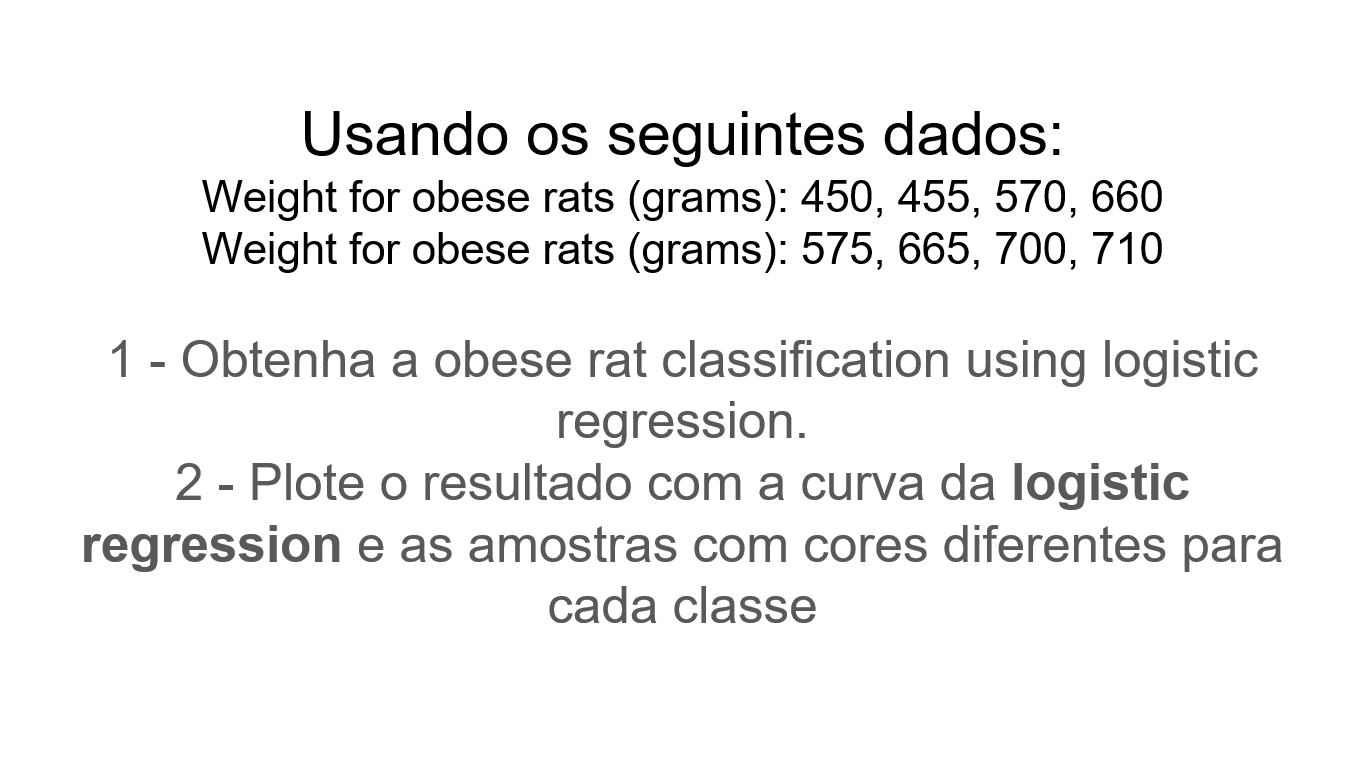
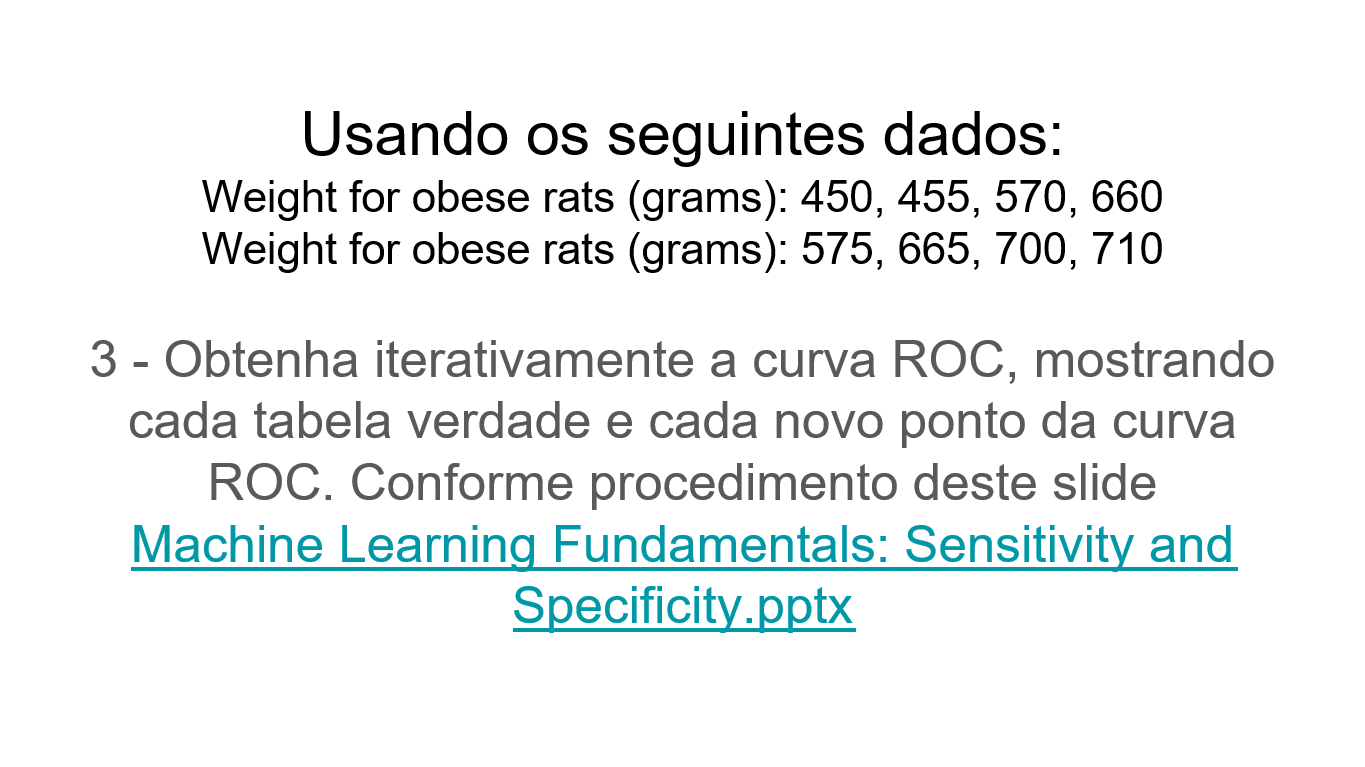

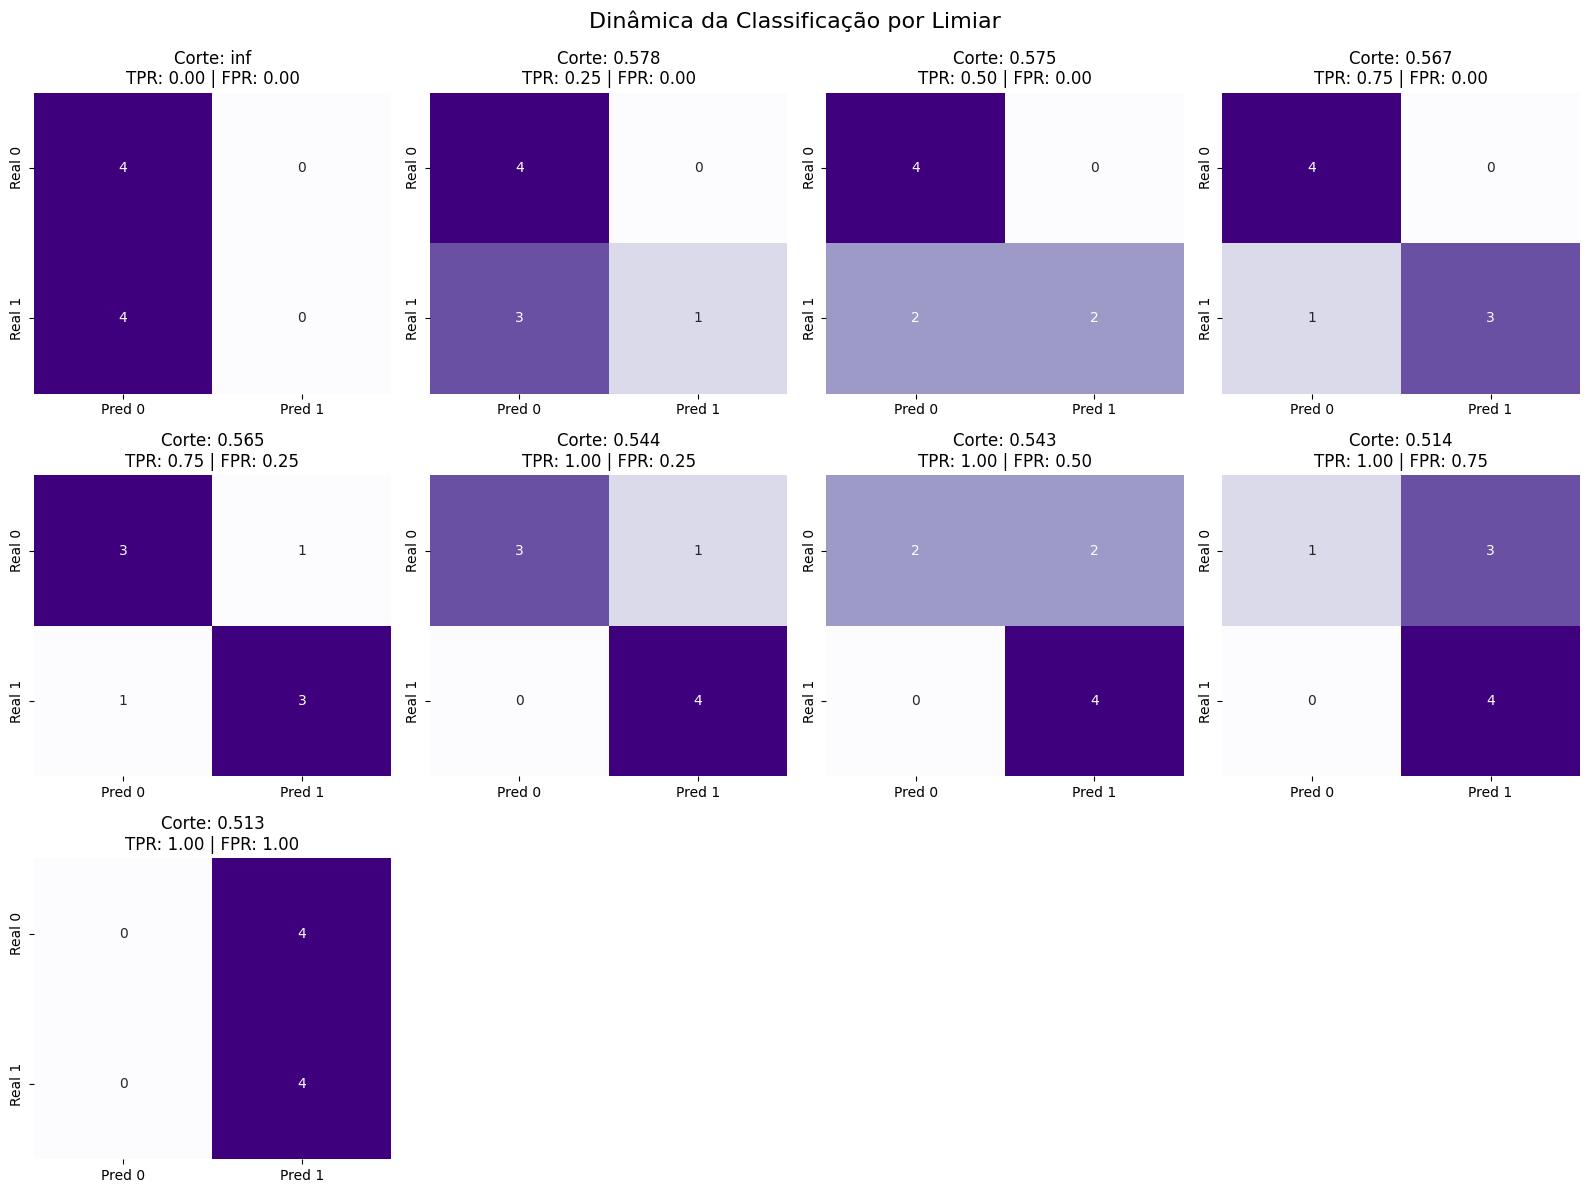

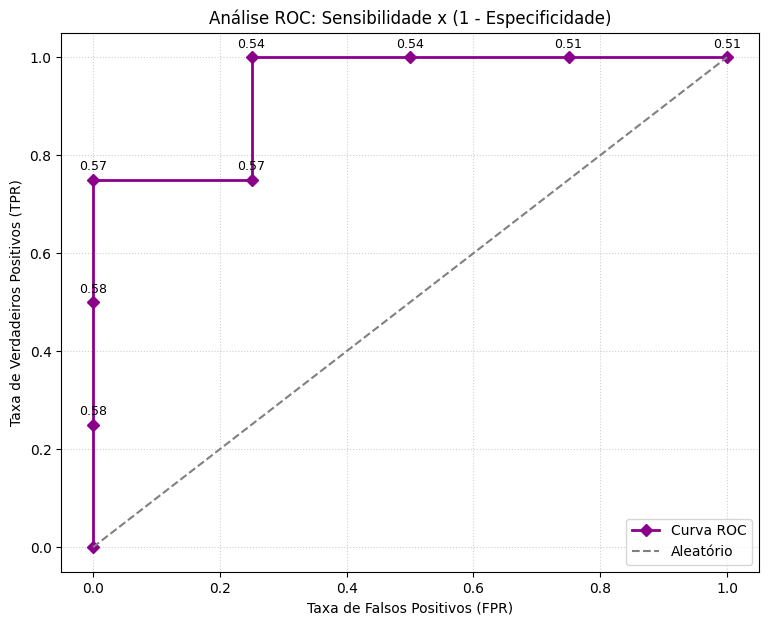

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import math

def processar_analise_roc_ratos(dados_entrada, rotulos_alvo):
    """
    Executa a regressão logística para classificação binária, exibindo visualmente a evolução da matriz de confusão para cada limiar de decisão e a curva ROC resultante.
    """
    modelo_regressao = LogisticRegression(solver='liblinear', random_state=42)
    modelo_regressao.fit(dados_entrada, rotulos_alvo)
    probs_classe_1 = modelo_regressao.predict_proba(dados_entrada)[:, 1]

    lista_limiares = np.r_[np.inf, np.sort(np.unique(probs_classe_1))[::-1]]

    num_plots = len(lista_limiares)
    cols_grid = 4
    lins_grid = math.ceil(num_plots / cols_grid)

    fig_cm, eixos_cm = plt.subplots(lins_grid, cols_grid, figsize=(16, 4 * lins_grid))
    fig_cm.suptitle('Dinâmica da Classificação por Limiar', fontsize=16, y=0.99)
    eixos_linear = eixos_cm.flatten()

    registros_metricas = []

    for idx, corte in enumerate(lista_limiares):
        previsoes_binarias = (probs_classe_1 >= corte).astype(int)
        tn_val, fp_val, fn_val, tp_val = confusion_matrix(rotulos_alvo, previsoes_binarias, labels=[0, 1]).ravel()

        taxa_verdadeiro_pos = tp_val / (tp_val + fn_val) if (tp_val + fn_val) > 0 else 0.0
        especificidade_real = tn_val / (tn_val + fp_val) if (tn_val + fp_val) > 0 else 0.0
        taxa_falso_pos = 1 - especificidade_real

        registros_metricas.append((taxa_falso_pos, taxa_verdadeiro_pos, corte))

        sns.heatmap([[tn_val, fp_val], [fn_val, tp_val]], annot=True, fmt='d', cmap='Purples', cbar=False, ax=eixos_linear[idx], xticklabels=['Pred 0', 'Pred 1'], yticklabels=['Real 0', 'Real 1'])
        eixos_linear[idx].set_title(f"Corte: {corte:.3f}\nTPR: {taxa_verdadeiro_pos:.2f} | FPR: {taxa_falso_pos:.2f}")

    for k in range(idx + 1, len(eixos_linear)):
        fig_cm.delaxes(eixos_linear[k])

    plt.tight_layout()
    plt.show()

    lista_fpr, lista_tpr, _ = zip(*registros_metricas)
    plt.figure(figsize=(9, 7))
    plt.plot(lista_fpr, lista_tpr, marker='D', linestyle='-', color='darkmagenta', linewidth=2, label='Curva ROC')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Aleatório')

    for fpr, tpr, limiar in registros_metricas:
        if limiar != np.inf:
            plt.text(fpr, tpr + 0.02, f"{limiar:.2f}", fontsize=9, ha='center', color='black')

    plt.title('Análise ROC: Sensibilidade x (1 - Especificidade)')
    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
    plt.legend(loc="lower right")
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()

pesos_grupo_a = [450, 455, 570, 660]
pesos_grupo_b = [575, 665, 700, 710]

matriz_input = np.array(pesos_grupo_a + pesos_grupo_b).reshape(-1, 1)
vetor_target = np.array([0] * len(pesos_grupo_a) + [1] * len(pesos_grupo_b))

processar_analise_roc_ratos(matriz_input, vetor_target)

Primeiro, comparei dois algoritmos: o Naive Bayes e o KNN. O que percebi foi curioso: o Naive Bayes é "teimoso", ele deu exatamente o mesmo resultado não importando se eu mexia na escala dos números ou não. Já o KNN foi o oposto: ele precisa que os dados estejam bem organizados. Quando usei a técnica de padronização (chamada Z-score), o KNN funcionou super bem e foi o campeão do teste, errando muito pouco na hora de diferenciar as flores mais parecidas.

Depois, fui investigar quantos vizinhos o KNN deve consultar para tomar uma decisão. Descobri que usar apenas 1 vizinho é ruim, porque o modelo fica instável e tenta decorar os dados em vez de aprender. Conforme fui aumentando esse número, o modelo ficou mais esperto. O número ideal foi 7 vizinhos: foi o ponto onde ele melhor equilibrou os acertos, ignorando informações inúteis e focando no padrão real das flores.

Por fim, no teste com os ratos, vi como funciona a regra de decisão (o "corte"). Aprendi que a classificação não é fixa. Se eu sou muito rigoroso para considerar um rato obeso, eu evito erros falsos, mas deixo passar alguns ratos doentes. Se eu sou mais flexível, acho todos os doentes, mas acabo classificando alguns saudáveis como doentes por engano. O gráfico final (a curva ROC) serviu justamente para mostrar essa troca: para ganhar de um lado, a gente sempre perde um pouquinho do outro.